In [1]:
import os
import datetime
from tqdm import tqdm

import cv2
import torch
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from PIL import Image

from models.Unet.Unet import Unet
from models.Unet.trainer import train
from datasets.datasets import preprocessing_label, preprocessing_image, Dataset_2H
from utils.utils import load_dm3, denoise, generate_density_from_position

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

from mpl_toolkits.axes_grid1 import ImageGrid

cuda


In [2]:
class Dataset_temp(Dataset):
    def __init__(self, transform):
        self.images = []
        for i in range(100):
            with Image.open(f'F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\data_2H_full\\{i}.png') as img:
                self.images.append(preprocessing_image(img).to(device))
        self.pos_mo = np.load('F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\label_2H_full\\pos_mo.npy')
        self.pos_te = np.load('F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\label_2H_full\\pos_te.npy')
        self.pos_mo[:, [0, 1]] = self.pos_mo[:, [1, 0]]
        self.pos_te[:, [0, 1]] = self.pos_te[:, [1, 0]]
        self.pos_mo = torch.as_tensor(self.pos_mo, dtype=torch.float32).to(device)
        self.pos_te = torch.as_tensor(self.pos_te, dtype=torch.float32).to(device)  
        self.transform = transform

    def __len__(self):
        return 4000

    def __getitem__(self, index):
        idx = index % 40
        image = self.images[idx]
        image, label = self.transform(image, self.pos_mo, self.pos_te)
        return image, label

class RandomGenerator_tensor(object):
    def __init__(self) -> None:
        pass

    def __call__(self, image, pos_mo, pos_te):
        image, pos_mo, pos_te, scale = random_resize_tensor(image.clone(), pos_mo.clone(), pos_te.clone())
        if random.random() > 0.5:
            image, pos_mo, pos_te = random_rotate_tensor(image, pos_mo, pos_te)
        width, std = int(np.round(256 * scale)), 1.7 * scale
        label_mo = generate_density_from_position_tensor(pos_mo, width, std)
        label_te = generate_density_from_position_tensor(pos_te, width, std)
        label_sum = torch.sum(torch.stack((label_mo, label_te)), dim=0)
        label_sum /= torch.max(label_sum)
        label_back = 1 - label_sum
        label = torch.stack((label_mo, label_te, label_back), dim=0).float()
        
        image, label = random_clip_tensor(image, label, crop_size=128)
        if random.random() > 0.5:
            image, label = random_rot_flip_tensor(image, label)
        return image, label

def random_resize_tensor(image, pos1, pos2):
    min_scale = 0.5
    max_scale = 2
    scale = random.uniform(min_scale, max_scale)
    new_size = (int(image.shape[1] * scale), int(image.shape[2] * scale))
    image = TF.resize(image, new_size, interpolation=TF.InterpolationMode.BICUBIC, antialias=True)
    pos1 = torch.round(pos1 * scale)
    pos2 = torch.round(pos2 * scale)
    return image, pos1, pos2, scale

def rotate_point(point, angle, center):
    center = center
    angle = torch.tensor(angle * torch.pi / 180)
    cos_val = torch.cos(angle).to(torch.float32)
    sin_val = torch.sin(angle).to(torch.float32)
    rotation_matrix = torch.tensor([
        [cos_val, -sin_val],
        [sin_val, cos_val]
    ], dtype=torch.float32)
    point = point - center
    point = torch.matmul(rotation_matrix, point.T).T
    point = point + center
    return point

def random_rotate_tensor(image, pos1, pos2):
    angle = torch.randint(-90, 90, (1,)).item()
    center = torch.tensor([image.shape[2] / 2, image.shape[1] / 2], dtype=torch.float32)
    image = TF.rotate(image, angle, interpolation=TF.InterpolationMode.BILINEAR)
    pos1 = rotate_point(pos1, -angle, center)
    pos2 = rotate_point(pos2, -angle, center)
    return image, pos1, pos2

def random_clip_tensor(image, label, crop_size=128):
    _, H, W = image.shape
    top = torch.randint(0, H - crop_size + 1, (1,)).item()
    left = torch.randint(0, W - crop_size + 1, (1,)).item()
    image_clipped = image[:, top:top + crop_size, left:left + crop_size]
    label_clipped = label[:, top:top + crop_size, left:left + crop_size]
    return image_clipped, label_clipped

def random_rot_flip_tensor(image, label):
    k = torch.randint(0, 4, (1,)).item()
    image = torch.rot90(image, k, [1, 2])
    label = torch.rot90(label, k, [1, 2])
    axis = torch.randint(0, 2, (1,)).item()
    if axis == 0:
        image = torch.flip(image, [2])
        label = torch.flip(label, [2])
    else:
        image = torch.flip(image, [1])
        label = torch.flip(label, [1])
    return image, label

def generate_density_from_position_tensor(position, width, std):
    image = torch.zeros((width, width), device=position.device, dtype=torch.float32)
    x, y = torch.meshgrid(torch.arange(width, device=position.device, dtype=torch.float32),
                          torch.arange(width, device=position.device, dtype=torch.float32), indexing='ij')
    for i in range(position.shape[0]):
        x0 = position[i, 1]
        y0 = position[i, 0]
        distance = torch.sqrt((x - x0)**2 + (y - y0)**2)
        gaussian = torch.exp(-(distance**2) / (2 * std**2))
        image += gaussian
    max_val = torch.max(image)
    if max_val > 0:
        image /= max_val
    return image

def Otsu(origin_image):
    image = renormalize(data_init(origin_image))
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, _, _, centroids = cv2.connectedComponentsWithStats(np.uint8(thresh), connectivity=4, ltype=cv2.CV_32S)
    centroids = np.array(centroids[1:])
    return centroids

def data_init(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def data_init_tensor(image):
    return (image - torch.min(image)) / (torch.max(image) - torch.min(image))

def renormalize(image):
    return np.uint8(image * 255)

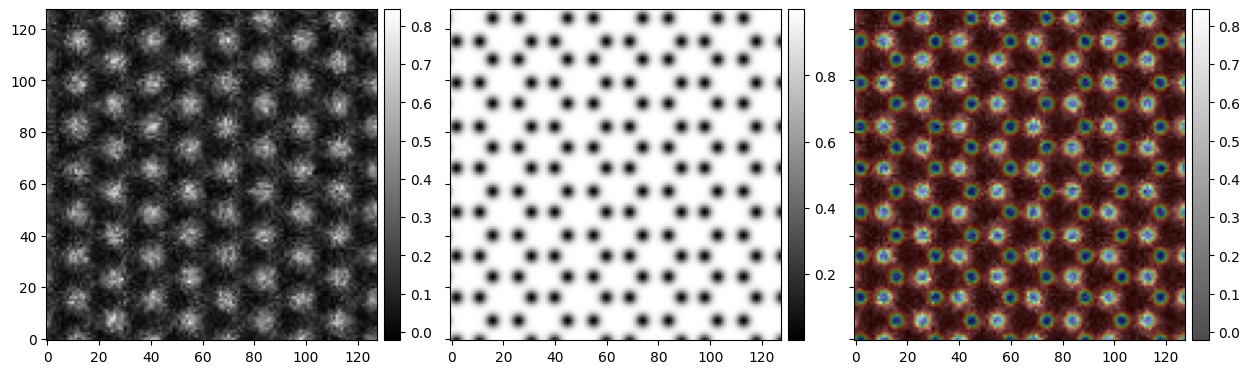

In [3]:
dataset = Dataset_temp(RandomGenerator_tensor())
image, label = dataset[2100]
fig = plt.figure(figsize=(15, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5, cbar_mode="each", cbar_size="5%", cbar_pad="2%")

im = grid[0].imshow(image[0].cpu(), cmap='gray')
grid[0].invert_yaxis()
grid.cbar_axes[0].colorbar(im)

im = grid[1].imshow(label[2].cpu(), cmap='gray')
grid[1].invert_yaxis()
grid.cbar_axes[1].colorbar(im)

im = grid[2].imshow(label[2].cpu(), cmap='jet')
im = grid[2].imshow(image[0].cpu(), alpha=0.7, cmap='gray')
grid[2].invert_yaxis()
grid.cbar_axes[2].colorbar(im)
plt.show()

In [4]:
# 数据增强
# for i in tqdm(range(4000)):
#     image, label = dataset[i]
#     torch.save(image.cpu(), f'F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\dataset_2H\\image_{i}.pth')
#     torch.save(label.cpu(), f'F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\dataset_2H\\label_{i}.pth')

100%|██████████| 4000/4000 [12:58<00:00,  5.14it/s]


In [96]:
# 加载增强数据
dataset = Dataset_2H()
# 计算划分的样本数量
ratio = 0.9
train_size = int(ratio * len(dataset))
valtest_size = len(dataset) - train_size
val_size = int(ratio * valtest_size)
test_size = valtest_size - val_size

# 使用 random_split 函数划分数据集
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(14128))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

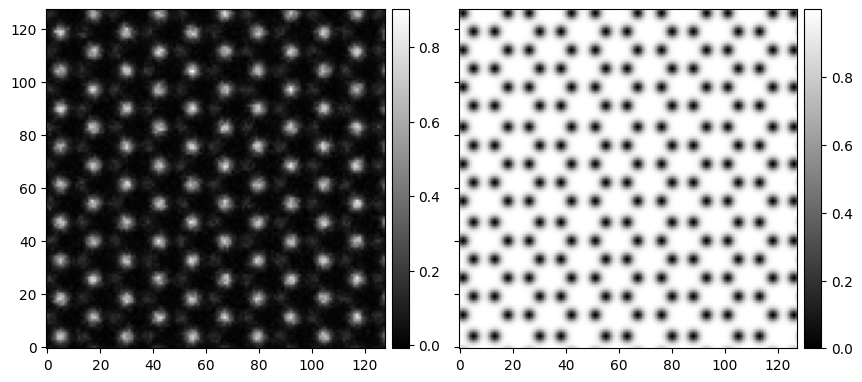

In [97]:
image, label = train_dataset[12]
fig = plt.figure(figsize=(10, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.5, cbar_mode="each", cbar_size="5%", cbar_pad="2%")

im = grid[0].imshow(image[0], cmap='gray')
grid[0].invert_yaxis()
grid.cbar_axes[0].colorbar(im)

im = grid[1].imshow(label[2], cmap='gray')
grid[1].invert_yaxis()
grid.cbar_axes[1].colorbar(im)
plt.show()

In [5]:
# 定义参数
epochs = 200
weight_decay = 0.0005
learning_rate_list =[0.005]
loss_type = ['CrossEntropyLoss', 'ModifiedMSE'][0]

In [ ]:
# 模型训练
for learning_rate in learning_rate_list:
    model = Unet(num_classes=3)
    info = '2H'
    current_time = datetime.datetime.now()
    current_time = datetime.datetime.strftime(current_time, r'%Y%m%d-%H%M%S')
    save_path = os.path.join('results', f'Unet_{current_time}_lr={learning_rate}_wd={weight_decay}_{info}')
    train(model, device, save_path, train_dataloader, learning_rate, weight_decay, epochs, loss_type)

In [14]:
model = Unet(num_classes=3)
model.load_state_dict(torch.load('F:\\QBC\\STEM-PyTorch-v2.0\\results\\Unet_20240418-152255_lr=0.005_wd=0.0005_2H\\weight.pth'))
model.eval()
model = model.to(device)
dataloader = DataLoader(dataset, batch_size=20, shuffle=False)
loop = tqdm(dataloader, total=len(dataloader))
idx = 0
for images, _ in loop:
    images = images.to(device)
    with torch.no_grad():
        out = model(images)
        out = F.softmax(out, dim=1)
    for i in range(out.shape[0]):
        pos_mo = Otsu(out[i][0].cpu().numpy())
        pos_te = Otsu(out[i][1].cpu().numpy())
        pos = np.concatenate((pos_mo, pos_te))
        intensity = images.cpu().numpy()[i][0][pos[:, 1].astype(int), pos[:, 0].astype(int)]
        pos = np.concatenate((pos, intensity[:, np.newaxis]), axis=1)
        label = np.concatenate((np.zeros(pos_mo.shape[0]), np.ones(pos_te.shape[0])), axis=0)
        np.save(f'F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\pos_2H\\{idx}_pos.npy', pos)
        np.save(f'F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\pos_2H\\{idx}_label.npy', label)
        idx += 1

100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


In [ ]:
model = Unet(num_classes=3)
model.load_state_dict(torch.load('F:\\QBC\\STEM-PyTorch-v2.0\\results\\Unet_20240418-152255_lr=0.005_wd=0.0005_2H\\weight.pth'))
model.eval()
image, _ = dataset[1]
with torch.no_grad():
    out = model(image.unsqueeze(0))
    out = F.softmax(out, dim=1)
pos_mo = Otsu(out[0][0].numpy())
pos_te = Otsu(out[0][1].numpy())
label = np.concatenate((np.zeros(pos_mo.shape[0]), np.ones(pos_te.shape[0])), axis=0)
print(pos_mo.shape)
print(pos_te.shape)
print(label.shape)
print(label)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.5, cbar_mode="each", cbar_size="5%", cbar_pad="2%")

im = grid[0].imshow(image[0], cmap='gray')
im = grid[0].scatter(pos_mo[:, 0], pos_mo[:, 1], c='r', s=10)
im = grid[0].scatter(pos_te[:, 0], pos_te[:, 1], c='b', s=10)
grid[0].invert_yaxis()
grid.cbar_axes[0].colorbar(im)

In [3]:
# 二分类网络
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import glob

class CoordinateTransformer(nn.Module):
    def __init__(self, coord_dim, num_classes):
        super(CoordinateTransformer, self).__init__()
        self.embedding = nn.Linear(coord_dim, 256, bias=False)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=256, nhead=8, batch_first=True),
            num_layers=12)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        mask = (x == 0).all(dim=2)
        x = self.transformer(x, src_key_padding_mask=mask)
        x = self.classifier(x)
        return x

def collate_fn(batch):
    # 解包批次数据
    pos, labels = zip(*batch)
    
    # 填充 pos 数据
    # pad_sequence 默认在序列的开始填充，但我们需要在末尾填充，所以设置 batch_first=True
    pos_padded = pad_sequence(pos, batch_first=True, padding_value=0.0)
    
    # 填充 labels 数据
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # 使用一个明显的错误类别索引，例如 -100，作为填充值
    
    return pos_padded, labels_padded

# 定义 Dataset
class Dataset_coord(Dataset):
    def __init__(self, base_path='F:\\QBC\\STEM-PyTorch-v2.0\\datasets\\mote2\\pos_2H'):
        self.base_path = base_path
        self.pos_files = glob.glob(os.path.join(base_path, '*_pos.npy'))
        self.label_files = glob.glob(os.path.join(base_path, '*_label.npy'))

    def __len__(self):
        return len(self.pos_files)

    def __getitem__(self, index):
        # pos = torch.as_tensor(np.load(self.pos_files[index]))[:, :-1]
        pos = torch.as_tensor(np.load(self.pos_files[index]))
        label = torch.as_tensor(np.load(self.label_files[index]), dtype=torch.long)
        return pos, label

In [4]:
dataset = Dataset_coord()
train_dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate_fn, shuffle=True)
model = CoordinateTransformer(coord_dim=3, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

# epochs = 100
# save_path = 'F:\\QBC\\STEM-PyTorch-v2.0\\results\\classifier'
# for e in range(epochs):
#     os.makedirs(save_path, exist_ok=True)
#     model = model.to(device)
#     model.train()
#     loop = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch [{e+1}/{epochs}]')
#     for pos, label in loop:
#         pos = pos.to(device=device, dtype=torch.float32)
#         label = label.to(device, dtype=torch.long)
#         pred = model(pos).transpose(1, 2)
#         loss = loss_fn(pred, label)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         loop.set_postfix({'loss': f'{loss.item():.6f}'})
#     scheduler.step()
#     if (e+1) % 5 == 0:
#         torch.save(model.state_dict(), f=os.path.join(save_path, 'weight.pth'))
#         torch.save(model, f=os.path.join(save_path, 'model.pth'))
#         print('Saved model and weights to disk.')

In [5]:
pos, label = dataset[0]

In [ ]:
print(pos[:, :-1])

In [112]:
model = Unet(num_classes=2)
model.load_state_dict(torch.load('F:\\QBC\\STEM-PyTorch-v2.0\\results\\Unet_20240409-130239_lr=0.005_wd=0.0005_gaussianMask\\weight.pth'))
model.eval()
image, _ = dataset[3]
with torch.no_grad():
    out = model(image.unsqueeze(0))
    out = F.softmax(out, dim=1)
coord = Otsu(out[0][1].numpy())
intensity = image[0][coord[:, 1].astype(int), coord[:, 0].astype(int)]
coord = np.concatenate((coord, intensity[:, np.newaxis]), axis=1)

model = CoordinateTransformer(coord_dim=3, num_classes=2)
model.load_state_dict(torch.load('F:\\QBC\\STEM-PyTorch-v2.0\\results\\classifier\\weight.pth'))
model.eval()
coord = torch.as_tensor(coord, dtype=torch.float32)
with torch.no_grad():
    out = model(coord.unsqueeze(0))
    pred = torch.argmax(out, dim=2)

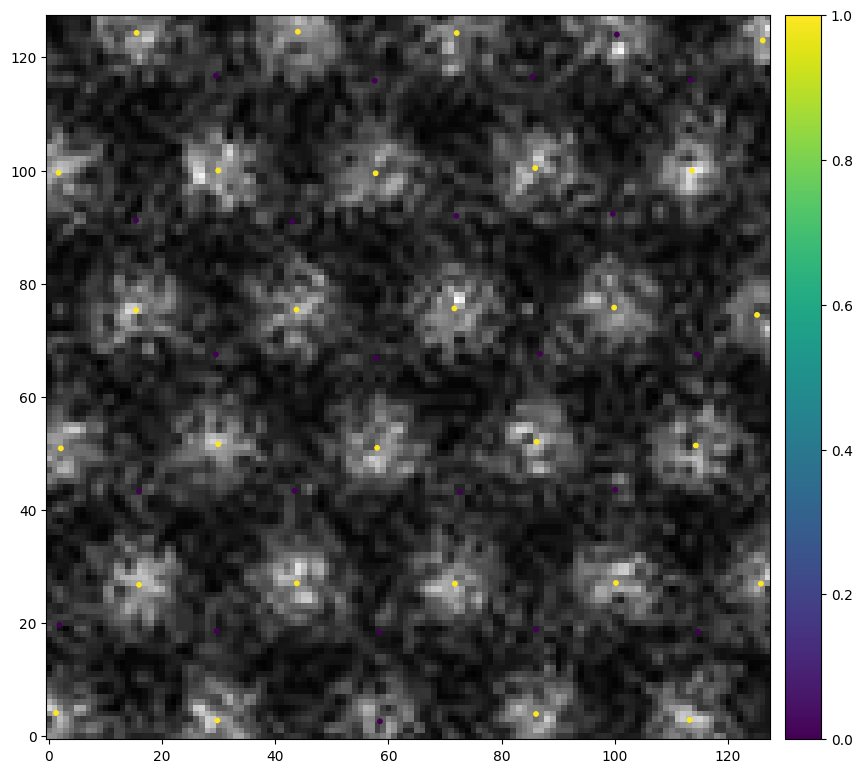

In [113]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.5, cbar_mode="each", cbar_size="5%", cbar_pad="2%")

im = grid[0].imshow(image[0], cmap='gray')
im = grid[0].scatter(coord[:, 0], coord[:, 1], c=pred[0], s=10)
grid[0].invert_yaxis()
grid.cbar_axes[0].colorbar(im)